Stacked Model Results:
Accuracy: 0.97
F1 Score: 0.97
Recall (Sensitivity): 0.95
Specificity: 0.99
AUC ROC: 0.99


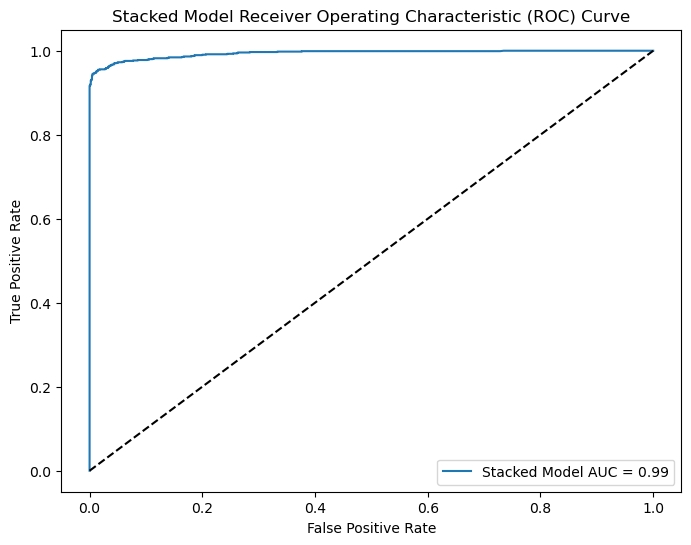

Random Forest Best Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': False}
XGBoost Best Parameters: {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.8}


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# Load your dataset
data = pd.read_csv("C:\\Users\\HP\\Downloads\\daa data set\\full_data.csv")

# Fill missing values using Simple Imputer
imputer = SimpleImputer(strategy='mean')
data_imputed = data.copy()
data_imputed['bmi'] = imputer.fit_transform(data_imputed[['bmi']])

# Convert categorical features to numerical using Label Encoding
label_encoder = LabelEncoder()
categorical_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for feature in categorical_features:
    data_imputed[feature] = label_encoder.fit_transform(data_imputed[feature])

# Separate features and target
X = data_imputed.drop('stroke', axis=1)  # Assuming 'stroke' is the target column
y = data_imputed['stroke']

# Feature Selection using Recursive Feature Elimination (RFE)
log_reg = LogisticRegression(max_iter=1000)
rfe = RFE(estimator=log_reg, n_features_to_select=8)
X_selected = rfe.fit_transform(X, y)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Standardize the feature values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize Random Forest and XGBoost Classifiers
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Define hyperparameter grids
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 5, 10]
}

# Perform Randomized Search with Cross-Validation for both models
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=rf_param_grid, cv=cv, scoring='f1', n_jobs=-1, n_iter=50, random_state=42)
xgb_random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=xgb_param_grid, cv=cv, scoring='f1', n_jobs=-1, n_iter=50, random_state=42)

# Fit the models
rf_random_search.fit(X_train, y_train)
xgb_random_search.fit(X_train, y_train)

# Best parameters and models
rf_best_model = rf_random_search.best_estimator_
xgb_best_model = xgb_random_search.best_estimator_

# Create a Voting Classifier (Stacking Random Forest and XGBoost)
voting_model = VotingClassifier(estimators=[('rf', rf_best_model), ('xgb', xgb_best_model)], voting='soft')
voting_model.fit(X_train, y_train)

# Function to evaluate and plot results with threshold adjustment
def evaluate_model_with_threshold(model, X_test, y_test, model_name, threshold=0.5):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba >= threshold).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Calculate specificity
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)

    # Print the results
    print(f'{model_name} Results:')
    print(f'Accuracy: {accuracy:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print(f'Recall (Sensitivity): {recall:.2f}')
    print(f'Specificity: {specificity:.2f}')
    print(f'AUC ROC: {roc_auc:.2f}')

    # Plotting the ROC Curve
    from sklearn.metrics import roc_curve

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Evaluate and plot results for the stacked model (Voting Classifier)
evaluate_model_with_threshold(voting_model, X_test, y_test, "Stacked Model", threshold=0.4)

# Print best parameters
print(f'Random Forest Best Parameters: {rf_random_search.best_params_}')
print(f'XGBoost Best Parameters: {xgb_random_search.best_params_}')
